# PEC1 - Generative Adversarial Networks
A partir del conjunto de datos CIFAR10, se debe entrenar una *DCGAN* (*Deep Convolutional Generative Adversarial Network*) para generar nuevas imágenes. Una vez implementada la red, se deberá agregar *experience replay* y comparar los resultados con los obtenidos en la red inicial. Por último, se deberá convertir la red en una GAN condicional. 

## Instrucciones
Se debe contestar a cada apartado de la práctica en el espacio correspondiente de esta plantilla. Los apartados que se deben contestar en lenguaje natural (utilizando las celdas de tipo Markdown), se han resaltado en amarillo. Se debe añadir debajo del texto resaltado la respuesta correspondiente. Cuando el texto subrayado indique algún requisito de la respuesta (por ejemplo en cuanto a longitud de la respuesta), será imprescindible ajustarse a dicho requisito. Los apartados que requieren código en Python deberán contestarse en los espacios de código previstos para ello. Al igual que las respuestas en celdas de tipo markdown, las respuestas de código pueden tener asociados requisitos especiales. Estos espacios se delimitan con la siguiente estructura:
``` python
# INICIO_RESPUESTA
# Requisitos: Elabore una función que siempre devuelva True

def mi_funcion() :
    return True

# FIN_RESPUESTA
```

## Esquema de la plantilla
El esquema de la memoria deberá ser el siguiente:

1. Explicar qué es una *DCGAN* y cómo funciona (haciendo énfasis en explicar las dos partes principales de este tipo de modelos) 
1. Describir brevemente el conjunto de datos inicial (*CIFAR10*)
1. Entrenar una *DCGAN (Deep Convolutional Generative Adversarial Network)* para generar imágenes.
1. Añadir *experience replay*
1. Convertir la red a una *GAN condicional*

En primer lugar vamos a cargar las librerías y funciones de apoyo que se van a utilizar en el código del cuadernillo. Si se quiere utilizar alguna librería adicional se puede añadir dicha librería en este punto o en la celda de código en la que se vaya a utilizar por primera vez.


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, BatchNormalization, Conv2DTranspose, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam

import sklearn
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Check for GPU
!nvidia-smi

print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


zsh:1: command not found: nvidia-smi
GPUs Available:  1


## Consideraciones iniciales

Dado el tiempo de cómputo que exigen este tipo de redes se limitará el análisis de 50 epochs. Es muy recomendable, también que, si no se dispone de una tarjeta gráfica y una configuración compatible con tensorflow (puede comprobarse con la última salida del bloque anterior, si el número de GPUs disponible es 0) se utilice para la realización de esta práctica Google Colab. En este plataforma deberemos configurar el entorno de ejecución para que soporte GPUs, esto puede hacerse a través del menú *Entorno de ejecución* y la opción *Cambiar tipo de entorno de ejecución*, selecconando **GPU** como *Acelerador por hardware* .

In [2]:
# Definimos las constantes que utilizaremos a lo largo del cuadernillo
batch_size = 128
epochs = 50
latent_dim = 100

Es importante saber que para poder depurar algunos métodos como «fit» debemos cambiar el modo de ejecución. Para ello podemos dar el valor «True» al parámetro «run_eagerly» cuando compilemos el modelo. Cuidado, al cambiar este parámetro la ejecución del código será mucho más lenta. Para más información y consejos de depuración se recomienda utilizar los consejos que se indican en la propia página de Keras (https://keras.io/examples/keras_recipes/debugging_tips/)

## Memoria
**Nombre:** Macià Salvà Salvà

**Correo UNED:** msalva26@alumno.uned.es

### ¿Qué es una DCGAN?
<mark>\[Respuesta: Explicar lo que es una DCGAN, extensión aproximada de 2 párrafos (200 palabras) \]</mark>


### CIFAR10
<mark>\[Respuesta: Describir brevemente el conjunto de datos CIFAR10, puede utilizar celdas de código para apoyarse en la descripción\]</mark>

In [3]:
from tensorflow import keras

# En primer lugar vamos a descargar el conjunto de datos
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

In [4]:
# INICIO_RESPUESTA 0/7
# Requisitos: De como valor de la variable «semilla_aleatoria» los últimos dos dígitos de su documento de identificación
#semilla_aleatoria = 03
semilla_aleatoria = 3
# FIN_RESPUESTA

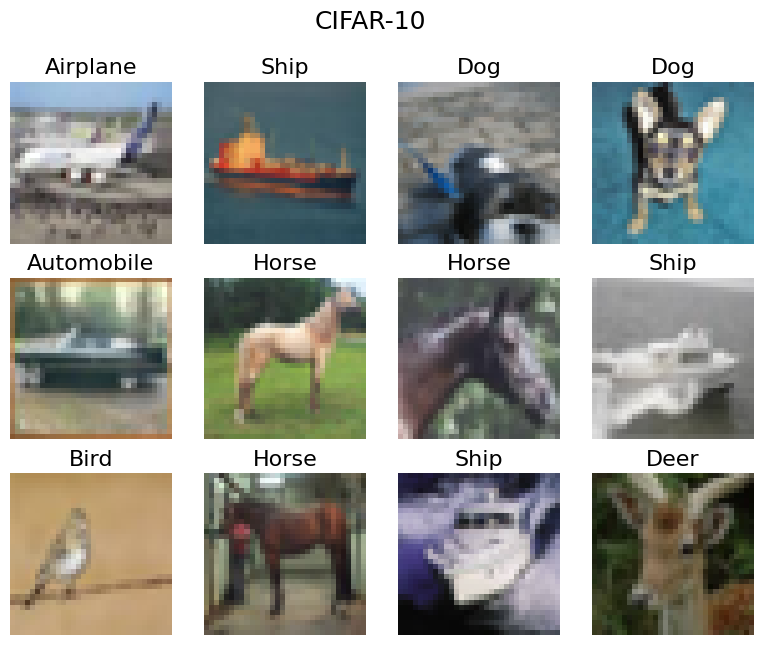

In [5]:
np.random.seed(semilla_aleatoria)
tf.random.set_seed(semilla_aleatoria)

# Vamos a visualizar un subconjunto de las imagenes que hemos cargado
clases = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.figure(figsize=(9.6,7.2))
plt.suptitle("CIFAR-10", size=18)
plt.subplots_adjust(wspace=0.2)

pos = 1
for n in np.random.randint(low=0,high=len(X_train),size=12):
    plt.subplot(3, 4, pos)
    plt.imshow(X_train[n])
    plt.axis('off')
    plt.title(clases[Y_train[n][0]], size=16)
    pos += 1
plt.show()

### Pre-procesado de datos
<mark>\[Respuesta: Describir los pasos de preprocesado que se han realizado así como la justificación de los mismos (tener en cuenta que se utilizará la función de activación tangencial hipèrbólica)\]</mark>

In [17]:
all_imgs = np.concatenate([X_train, X_test])
all_labels = np.concatenate([Y_train, Y_test])

all_imgs[1].shape

(32, 32, 3)

In [19]:
# Dado que no tendremos una estructura de entrenamiento y validación, vamos a juntar todos las imágenes
all_imgs = np.concatenate([X_train, X_test])
all_labels = np.concatenate([Y_train, Y_test])

# INICIO_RESPUESTA 1/7
# Requisitos: Realice el pre-procesado de los datos de entrada teniendo en cuenta las recomendaciones que se indican en el capítulo 17 del libro, guarde el resultado en all_imgs.
all_imgs = all_imgs.astype(np.float32) / 255
# FIN_RESPUESTA    

In [20]:
print(all_imgs.min())
print(all_imgs.mean())
print(all_imgs.max())

0.0
0.47390243
1.0


### DCGAN Inicial
En este apartado se quiere crear una primera red usando la API secuencial de Keras.  Es importante en este punto revisar las recomendaciones que se presentan en el capítulo 17 del libro:

<mark>\[Respuesta: Describir las recomendaciones que se presentan en el capítulo 17 del libro. Si, tras la evaluación de estas recomendaciones se detectan inconsistencias o no se siguen todas, indicar por qué.\]</mark>



#### Generador

Para el generador se utilizará la siguiente estructura:

1. Capa densa y reshape a 8 x 8 x 128 
2. Capa de convolución transpuesta con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
3. Capa de convolución transpuesta con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
4. Capa convolucional con 3 filtros (kernel de 3x3, 1 stride, padding 'same' y función de activación 'tanh')

Todas las capas convolucionales transpuestas tienen una función de activación Leaky ReLU (únicamente las transpuestas) y, tras cada capa se aplicará normalización por lotes (BatchNormalization).

In [ ]:
generator = keras.models.Sequential([
    keras.layers.Input(shape=(100,)),  
    # INICIO_RESPUESTA 2/
    # Requisitos: Añada las capas indicadas para el generador
    keras.layers.Dense(8*8*128),
    keras.layers.Reshape([8,8,128]),
    tf.keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.BatchNormalization(),
    keras.layers.Conv2D(3, kernel_size=3, strides=1, padding="same", activation="tanh")
    # FIN_RESPUESTA 
])

generator.summary()

ValueError: Exception encountered when calling layer "reshape_1" (type Reshape).

total size of new array must be unchanged, input_shape = [8192], output_shape = [7, 7, 128]

Call arguments received by layer "reshape_1" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 8192), dtype=float32)

#### Discriminador

Para el Discriminador se utilizará la siguiente estructura:

1. Capa convolucional con 32 filtros (kernel de 4x4, 2 strides y padding 'same')
2. Capa convolucional con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
3. Capa convolucioanl con 128 filtros (kernel de 4x4, 2 strides y padding 'same')
4. Capa Densa con función de activación sigmoide

Todas las capas convolucionales tienen una función de activación Leaky ReLU y, posteriormente se aplicarán normalización (BatchNormalization) y Dropout. Salvo la última capa convolucional que no aplicará normalización si no que aplanará el resultado de cara a la última capa densa.

In [ ]:
discriminator = keras.models.Sequential([
# INICIO_RESPUESTA 3/7
# Requisitos: Añada las capas indicadas para el discriminador

# FIN_RESPUESTA 
])

discriminator.summary()

#### Modelo
<mark>\[Respuesta: Explicar los pasos de entrenamiento de una GAN, diferenciando el proceso de entrenamiento del generador y del discriminador. \]</mark>

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        generated_images = self.generator(random_latent_vectors)
        
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100, show_range=10, enable_show=True, enable_save=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.show_range = show_range
        self.enable_show = enable_show
        self.enable_save = enable_save

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % self.show_range) == 0 or epoch == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          generated_images = self.model.generator(random_latent_vectors)
          generated_images += 1
          generated_images /= 2

          generated_images.numpy()
          plt.figure(figsize=(self.num_img, 1))
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              if self.enable_show:
                plt.subplot(1, self.num_img, i + 1)
                plt.imshow(img, cmap="binary")
                plt.axis("off")
              if self.enable_save:
                img.save("generated_img_%03d_%d.png" % (epoch, i))
          if self.enable_show:
            plt.show()

In [ ]:
def plt_loss(history): 
    '''
    Función que nos ayudará a visualizar la evolución de las pérdidas del generador y del discriminador
    '''
    f_num = "{:.3f}"
    plt.figure(figsize=(12,5))
    plt.suptitle("Función de pérdida", size=18)
    plt.subplots_adjust(wspace=0.5, hspace = 0.5)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['d_loss'])
    plt.title("Discriminador")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['g_loss'])
    plt.title("Generador")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.tight_layout(pad=4)
    plt.show()
    print(f"Pérdida discriminador: Min ({f_num.format(np.min(history.history['d_loss']))}) Max ({f_num.format(np.max(history.history['d_loss']))}) Media ({f_num.format(np.mean(history.history['d_loss']))})")
    print(f"Pérdida generador: Min ({f_num.format(np.min(history.history['g_loss']))}) Max ({f_num.format(np.max(history.history['g_loss']))}) Media ({f_num.format(np.mean(history.history['g_loss']))})")

#### Optimizadores y función de pérdida
<mark>\[Respuesta: Explicar qué optimizadores se utilizarán para el discriminador y el generador y por qué. \]</mark>

In [ ]:
# INICIO_RESPUESTA 4/7
# Requisitos: Inicialice los optimizadores que se utilizarán para el discriminador y para el generador, se aconseja utilizar valores LR de aproximadamente 0.0002
d_optimizer = 
g_optimizer = 
# FIN_RESPUESTA 

loss_fn = keras.losses.BinaryCrossentropy()

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(all_imgs).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn,
)

history = gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

In [ ]:
plt_loss(history)

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando la evolución de las pérdidas del discriminador y del generador. \]</mark>

### Experience replay
<mark>\[Respuesta: Explicar en qué consiste la técnica de *Experience replay* y qué resultados se esperan de su uso. \]</mark>


<mark>\[Respuesta: Explicar qué estrategia de *Experience replay* (de las muchas posibles) se ha implementado en el modelo que hay a continuación. \]</mark>

#### Modelo

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.experience_replay = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        generated_images = self.generator(random_latent_vectors)
        
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # INICIO_RESPUESTA 5/7
        # Requisitos: Implementar una estrategia de Experience replay a partir de un buffer de imágenes alamacenadas en cada iteración
        
        # FIN_RESPUESTA 
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
gan_er = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan_er.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn,
)

history = gan_er.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

In [ ]:
plt_loss(history)

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando y compararlos con los obtenidos en la GAN sin *Experience replay*. \]</mark>

### GAN condicional
<mark>\[Respuesta: Explicar en qué consisten las GAN condicionales y qué resultados se esperan de estos modelos en relación al modelo original y al modelo con *Experience replay*. \]</mark>

#### Discriminador
<mark>\[Respuesta: Explicar las adaptaciones que necesitará el discriminador para realizar la discriminación basado en la clase. \]</mark>

In [ ]:
# INICIO_RESPUESTA 6/7
# Requisitos: Implemente el discriminador para la GAN condicional, utilice la estructura del discriminador original y adáptela para que funcione con las etiquetas de clase
#             (utilice la variable «discriminator» para almacenar el discriminador tal y como se hizo en el caso base)
# Nota: se recomienda utilizar la API funcional para desarrollar este apartado.

# FIN_RESPUESTA 

#### Generador
<mark>\[Respuesta: Explicar las adaptaciones que necesitará el generador para generar imágenes de una clase determinada. \]</mark>

In [ ]:
# INICIO_RESPUESTA 7/7
# Requisitos: Implemente el generador para la GAN condicional, utilice la estructura del generador original y adáptela para que funcione con las etiquetas de clase 
#             (utilice la variable «generator» para almacenar el generador tal y como se hizo en el caso base)
# Nota: se recomienda utilizar la API funcional para desarrollar este apartado.

# FIN_RESPUESTA 

#### Modelo

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.experience_replay = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images[0])[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator([real_images[1],random_latent_vectors])

        combined_images = tf.concat([generated_images, real_images[0]], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        combined_labels = tf.concat([real_images[1], real_images[1]], axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator([real_images[1],random_latent_vectors]), real_images[1]])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))


        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, y_train_enc = None, num_img=3, latent_dim=100, show_range=10,
                 enable_show=True, enable_save=False,
                 batch_size = 128):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.show_range = show_range
        self.enable_show = enable_show
        self.enable_save = enable_save
        self.batch_size = batch_size
        self.y_train_enc = y_train_enc

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % self.show_range) == 0 or epoch == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          labels = self.y_train_enc[epoch:epoch+self.num_img]
          generated_images = self.model.generator([labels,random_latent_vectors])
          generated_images = (generated_images + 1) / 2.0
          
          generated_images.numpy()
          plt.figure(figsize=(self.num_img, 1))
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              if self.enable_show:
                plt.subplot(1, self.num_img, i + 1)
                plt.imshow(img, cmap="binary")
                plt.axis("off")
              if self.enable_save:
                img.save("generated_img_%03d_%d.png" % (epoch, i))
          if self.enable_show:
            plt.show()

In [ ]:
# Dado que ahora el generador y el discriminador utilizarán la clase de cada elemento, es necesario utilizar las etiquetas, transformándolas previamente a un array
all_labels_enc = keras.utils.to_categorical(all_labels, 10)
dataset = tf.data.Dataset.from_tensor_slices((all_imgs, all_labels_enc)).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
conditional_gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
conditional_gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn
)

history = conditional_gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(all_labels_enc,
                                                                num_img=10,
                                                                latent_dim=latent_dim)])

In [ ]:
plt_loss(history)

In [ ]:
classes_labels = keras.utils.to_categorical([x for x in range(10)] * 4, 10)

random_latent_vectors = tf.random.normal(shape=(len(classes_labels), latent_dim))
generated_images = conditional_gan.generator([classes_labels,random_latent_vectors])
generated_images = (generated_images + 1) / 2.0
# generated_images.numpy()
plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
pos = 1
classes_to_int = np.argmax(classes_labels, axis=-1)
for n in range(generated_images.shape[0]):
    plt.subplot(4, 10, pos)
    img = keras.preprocessing.image.array_to_img(generated_images[n])
    plt.imshow(img)
    plt.axis('off')
    plt.title(clases[classes_to_int[n]], size=12)
    pos += 1
plt.show()

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando y compararlos con los obtenidos en la GAN que se ha utilizado como base y la GAN con *Experience replay*. \]</mark>

### Conclusiones finales
<mark>\[Respuesta: Resumir el trabajo realizado y las conclusiones principales que se extraen del mismo. \]</mark>

### (Opcional) Cycle-GANs 
<mark>\[Respuesta: Buscar información de las *Cycle GANs* y resumir su funcionamiento, haciendo especial énfasis en las novedades que introducen sobre las tipologías vistas en esta práctica . \]</mark>